In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import scipy.sparse as sparse
from matplotlib import animation as anim
from IPython.display import HTML

import sympy as sp
sp.init_printing(use_latex=True, use_unicode=True)

After a bit of massaging, the heat equation $$\frac{\partial u(x, t)}{\partial t} = \alpha \frac{\partial^2 u(x, t)}{\partial x^2}$$ can be rewrittem in terms of finite differences. Assuming that the separation of variables still applies, you can break down the solution $u(x, t)$ into two component functions $f(x)g(t)$. Since $\alpha$ will *not* depend on $x$, the analytic solution of $g(t)$ will be just fine: $$g(t) = G_0e^{ct}$$ where $c$ is some constant from $$\alpha(x)f^{\prime\prime} = cf$$

From the Neumann boundary conditions, $$\frac{\partial f}{\partial x}\approx\frac{f_{1} - f_{-1}}{2 \Delta x} = 0$$ This implies that $$f_{-1} = f_{1}$$ If we take the finite difference approximation of the second derivative on the boundary,
$$\frac{f_{1} - 2f_{0} + f_{-1}}{\Delta x^2} = \frac{2f_{1} - 2f_{0}}{\Delta x^2}$$ This means we can correct the standard "1, -2, 1" pattern in the matrix ${\bf A}$ on the first and last rows to reflect this boundary condition.

In [42]:
class HeatState(object):
    def __init__(self, N=201, L=3., **opts):
        self.opts = opts
        self.N    = N
        self.L    = L
        self.dx   = L / np.float64(N)
        self.x    = np.arange(N) * self.dx
        
        self.evals = None
        self.evecs = None
        
        self.a = None
    
    def alpha(self):
        return 1.*self.dx**(-2.)*np.ones(self.N)
    
    def A(self):
        alpha = np.diag(self.alpha())
        diags = sparse.diags([1., -2., 1.], offsets=[-1, 0, 1], 
                             shape=(self.N, self.N)).toarray()
        diags[0][1]               = 2.
        diags[self.N-1][self.N-2] = 2.
        
        self._A = alpha.dot(diags)
        return self._A
    
    def eigensystem(self):
        if self.evals is None and self.evecs is None:
            vals, vecs = np.linalg.eig(self.A())

            isort = np.argsort(vals)
            self.evals  = vals[isort]
            self.evecs = vecs[:, isort]
            return self
        else:
            # Eigensystem already built
            return self
    
    def set_weights(self, a):
        self.a = a
    
    def eigen_cast(self, arr):
        U, w, VT = np.linalg.svd(self.eigensystem().evecs)
        indices  = np.where(w > 1e-15)[0]
        winv     = np.zeros(len(w))
        winv     = 1. / w[indices]
        einv     = VT.T.dot(np.diag(winv)).dot(U.T)
        
        return einv.dot(arr)
    
    def time_evolve(self, N_FRAMES = 60, T = 2., ylim=[-1,1]):
        fig, ax = plt.subplots()
        
        a     = self.a
        x     = self.x
        evals = self.eigensystem().evals
        evecs = self.evecs
        
        ax.set_xlim([0, self.L])
        ax.set_ylim(ylim)
        
        plt.ioff()
        line, = ax.plot([], [], lw=2);

        def init_frame():
            line.set_data([], [])
            return line,
    
        def step(i):
            t     = T * (np.float64(i) / np.float64(N_FRAMES))
            coeff = a * np.exp(evals * t)

            u = evecs.dot(coeff).flatten()

            line.set_data(x, u)
            return (line,)
        
        obj = anim.FuncAnimation(fig, step, 
                                 init_func=init_frame, 
                                 frames=N_FRAMES, 
                                 interval=33, blit=True)
        plt.close(fig)
        return obj

Initializing the HeatState object:

In [3]:
# HeatState
state = HeatState().eigensystem()

Let's look at the eigenvectors of the state to compare with the analytic solution:

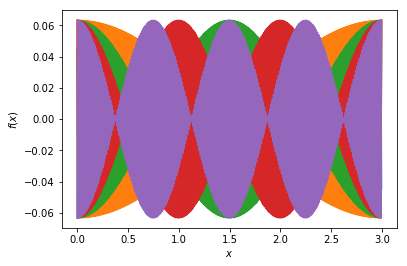

In [62]:
plt.figure()

for i in range(5):
    plt.plot(state.x, state.evecs[:, i])

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

These definitely have the cosine envelope that we are looking for! Let's try a case where $N$ (the grid size) is fairly small:

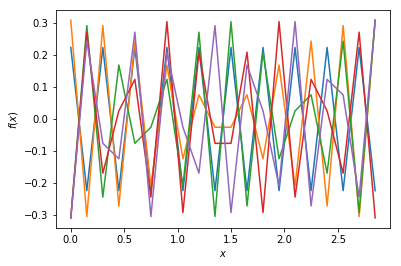

In [61]:
state1 = HeatState(N = 20).eigensystem()

plt.figure()

for i in range(5):
    plt.plot(state1.x, state1.evecs[:, i])

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

It's pretty evident that with low $N$ the domain is too sparsely covered for an accurate simulation of the heat equation. Let's try with $N=100$:

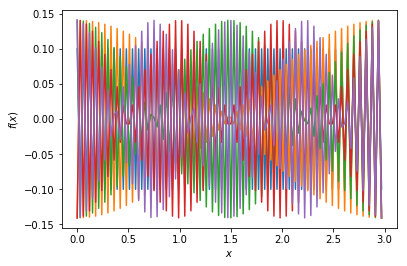

In [60]:
state1 = HeatState(N = 100).eigensystem()

plt.figure()

for i in range(5):
    plt.plot(state1.x, state1.evecs[:, i])

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

This is better, but still not that great. The initial choice of $N=200$ was pretty well covered, so any $N$ above 200 should suffice for a decent approximation.

Let's set the state up with $N=500$ and set an initial Gaussian heat source in the middle of the bar:

In [27]:
state = HeatState(N=500)

initial_conditions = mlab.normpdf(state.x, state.L / 2., 0.5)
state.set_weights(state.eigen_cast(initial_conditions))

an = state.time_evolve(N_FRAMES = 200, T = 2.)

HTML(an.to_html5_video())

This is a slowed-down study of heat diffusion over $T = 2s$. The video is $\sim30$fps with 200 frames, so the video is slowed down to about 30% of real time. The heat packet diffuses quickly to raise $u(x, t)$ to $\sim0.25$ uniformly. This agrees with the physical principle of thermal equilibrium.

Suppose we change the static form of $\alpha(x)$ to not be constant and make it act like some form of barrier on the left side of the frame:

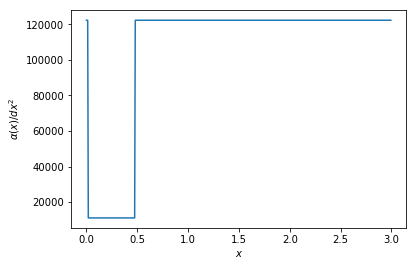

In [66]:
class BarrierHeatState(HeatState):
    def alpha(self):
        base = 4.4
        bar  = 0.4
        vals = np.arange(3, 80)
        
        alp       = base*np.ones(self.N)
        alp[vals] = bar
        
        return 1.*self.dx**(-2.)*alp

barstate = BarrierHeatState(N = 500)

plt.figure()
plt.plot(barstate.x, barstate.alpha())
plt.xlabel('$x$')
plt.ylabel('$\\alpha(x) / dx^{2}$')
plt.show()

Theoretically, the heat source should diffuse more to the right than to the left because of the lower conductivity "barrier" on the left side.

In [54]:
initial_conditions = mlab.normpdf(barstate.x, barstate.L / 2., 0.5)
barstate.set_weights(barstate.eigen_cast(initial_conditions))

an = barstate.time_evolve(N_FRAMES = 200, T = 2.)

HTML(an.to_html5_video())

As the heat source hits the zone with the lower conductivity, it diffuses more to the right than the left!

Let's look at a periodic conductivity pattern throughout the bar:

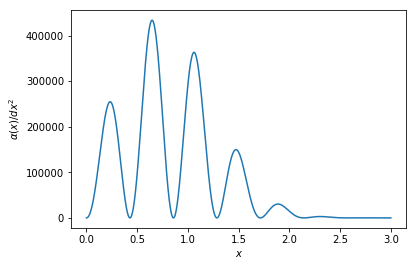

In [99]:
class PeriodicHeatState(HeatState):
    def alpha(self):
        mag = 0.2
        n   = 7
        
        alp = mag * mlab.normpdf(self.x, self.L / 4, 0.5) * np.cos(((np.pi * n) / self.L) * (self.x - self.L / 2.))**2.
        
        return 1.*self.dx**(-2.)*alp

perstate = PeriodicHeatState(N = 5000)

plt.figure()
plt.plot(perstate.x, perstate.alpha())
plt.xlabel('$x$')
plt.ylabel('$\\alpha(x) / dx^{2}$')
plt.show()

In [100]:
initial_conditions = mlab.normpdf(perstate.x, perstate.L / 2., 0.5)
perstate.set_weights(perstate.eigen_cast(initial_conditions))

an = perstate.time_evolve(N_FRAMES = 100, T = 2.)

HTML(an.to_html5_video())

After a fairly long render time, this periodic-normal conductivity behavior produces shocks! In order to check that this render wasn't the result of numerical instability, I set $N=5000$ to verify that the shocks present would persist at a finer grid spacing. The leftmost growth in $u(x, t)$ seems the least physical considering the definition of $\alpha(x)$ does not permit thermal conductivity at $x=0$. However, this is definitely an interesting render!